## Projeto de Classificação (Churn)
### Projeto para desenvolver um modelo preditivo, para prever os clientes que fariam churn em um banco

#### Análise Exploratória e Descritiva


##### 0.1 Importando Bibliotecas

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from scipy.stats import shapiro

#### 0.2 Carregando e Visualizando os dados

In [2]:
dados = pd.read_csv('dados_friance.csv')

C:\Users\Sávio\AppData\Local\Temp\ipykernel_21380\620884317.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv('dados_friance.csv')


In [3]:
dados.head()

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,2023,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,...,1,0,0,0,1,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0
1,2024,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,...,1,0,0,0,1,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0
2,1236,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,...,1,0,0,0,1,0.0,0.0,0.0,0.25,400.0
3,1362,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,...,1,0,0,0,1,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0
4,491,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,...,0,0,1,0,1,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0


In [4]:
# Removendo as colunas especificadas
dados2 = dados.drop(columns=['Cred_Bal_Sal', 'Bal_sal', 'Tenure_Age', 'Age_Tenure_product', 'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2', 'Surname_tfidf_3', 'Surname_tfidf_4'])


In [5]:
dados2.head()

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,Mem__no__Products
0,2023,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,1,0,0,0,1,0.0
1,2024,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,1,0,0,0,1,2.0
2,1236,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,1,0,0,0,1,0.0
3,1362,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,1,0,0,0,1,1.0
4,491,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,0,0,1,0,1,2.0


#### 0.3 Estrutura dos dados (Colunas ou Variáveis)

In [6]:
print(dados2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175028 entries, 0 to 175027
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Surname            175028 non-null  int64  
 1   CreditScore        175028 non-null  float64
 2   Age                175028 non-null  float64
 3   Tenure             175028 non-null  float64
 4   Balance            175028 non-null  float64
 5   NumOfProducts      175028 non-null  float64
 6   HasCrCard          175028 non-null  int64  
 7   IsActiveMember     175028 non-null  int64  
 8   EstimatedSalary    175028 non-null  object 
 9   Exited             175028 non-null  int64  
 10  France             175028 non-null  int64  
 11  Germany            175028 non-null  int64  
 12  Spain              175028 non-null  int64  
 13  Female             175028 non-null  int64  
 14  Male               175028 non-null  int64  
 15  Mem__no__Products  175028 non-null  float64
dtypes:

In [7]:
# Tentar converter os valores da coluna EstimatedSalary em números
dados2['EstimatedSalary_numeric'] = pd.to_numeric(dados2['EstimatedSalary'], errors='coerce')

# Filtrar os valores não numéricos
valores_nao_numericos = dados2[dados2['EstimatedSalary_numeric'].isna()]['EstimatedSalary']

print("Valores não numéricos na coluna EstimatedSalary:")
print(valores_nao_numericos)

Valores não numéricos na coluna EstimatedSalary:
53856     38.190.168
159796    14.012.017
Name: EstimatedSalary, dtype: object


In [8]:
dados2.shape

(175028, 17)

In [9]:
# Converter os valores da coluna EstimatedSalary para números, e usar o parâmetro errors='coerce' para converter os valores não numéricos para NaN
dados2['EstimatedSalary'] = pd.to_numeric(dados2['EstimatedSalary'], errors='coerce')

# Remover as linhas onde o valor da coluna EstimatedSalary é NaN
dados3 = dados2.dropna(subset=['EstimatedSalary'])

# Resetar o índice após remover as linhas
dados3 = dados3.reset_index(drop=True)

In [10]:
#Números de Linhas x Colunas
dados3.shape

(175026, 17)

#### 0.4 Estatísticas descritivas

In [11]:
print(dados3.describe())

             Surname  CreditScore            Age         Tenure  \
count  175026.000000  175026.0000  175026.000000  175026.000000   
mean     1617.463560     656.1132      38.171282       5.019951   
std       813.849068      81.1486       8.969570       2.811166   
min         0.000000     350.0000      18.000000       0.000000   
25%       949.000000     597.0000      32.000000       3.000000   
50%      1666.000000     659.0000      37.000000       5.000000   
75%      2292.000000     710.0000      42.000000       7.000000   
max      2931.000000     850.0000      92.000000      10.000000   

             Balance  NumOfProducts      HasCrCard  IsActiveMember  \
count  175026.000000  175026.000000  175026.000000   175026.000000   
mean    56676.655278       1.553066       0.751186        0.498754   
std     62982.362879       0.549213       0.432327        0.500000   
min         0.000000       1.000000       0.000000        0.000000   
25%         0.000000       1.000000       1.00

#### 0.5 Explorar relações entre variáveis

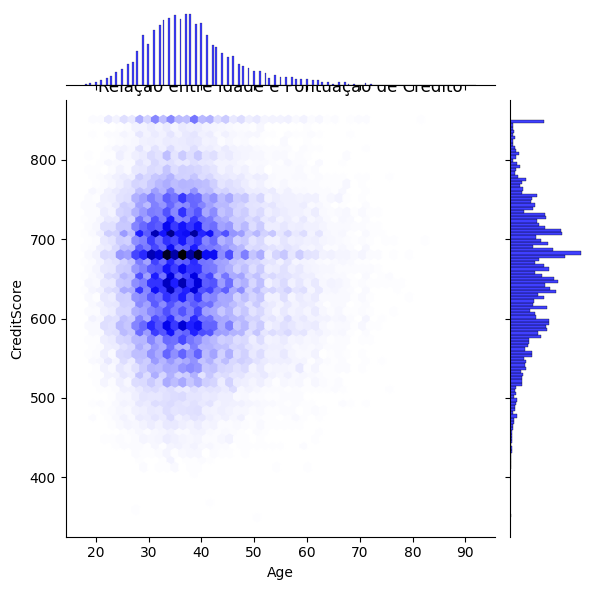

In [12]:
# Relação entre a pontuação de crédito (CreditScore) e a idade (Age)
sns.jointplot(x='Age', y='CreditScore', data=dados3, kind='hex', color='blue')
plt.title('Relação entre Idade e Pontuação de Crédito')
plt.show()

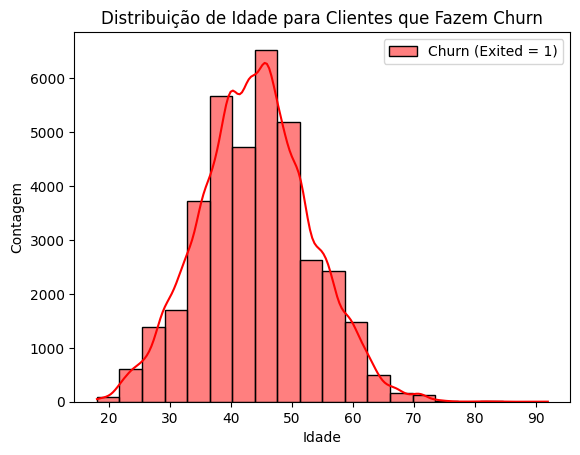

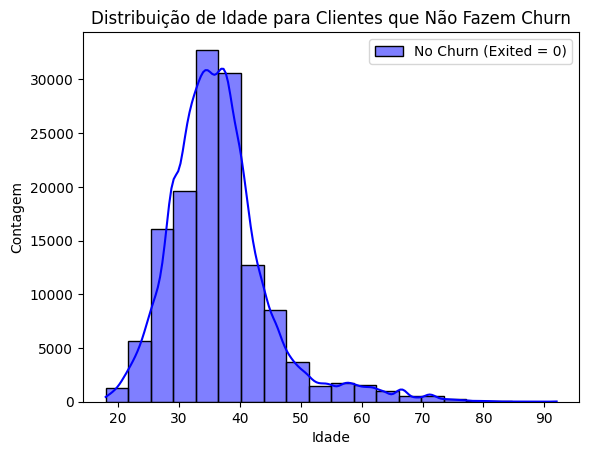

In [13]:
# Filtrando os dados para clientes que fazem e não fazem churn
churn_clients = dados3[dados3['Exited'] == 1]
non_churn_clients = dados3[dados3['Exited'] == 0]

# Distribuição de idade para clientes que fazem churn
sns.histplot(data=churn_clients, x='Age', bins=20, kde=True, color='red', label='Churn (Exited = 1)')
plt.title('Distribuição de Idade para Clientes que Fazem Churn')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.legend()
plt.show()

# Distribuição de idade para clientes que não fazem churn
sns.histplot(data=non_churn_clients, x='Age', bins=20, kde=True, color='blue', label='No Churn (Exited = 0)')
plt.title('Distribuição de Idade para Clientes que Não Fazem Churn')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.legend()
plt.show()

C:\Users\Sávio\AppData\Local\Temp\ipykernel_21380\2899540784.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_percent = dados3.groupby('Faixa de Idade')['Exited'].mean() * 100


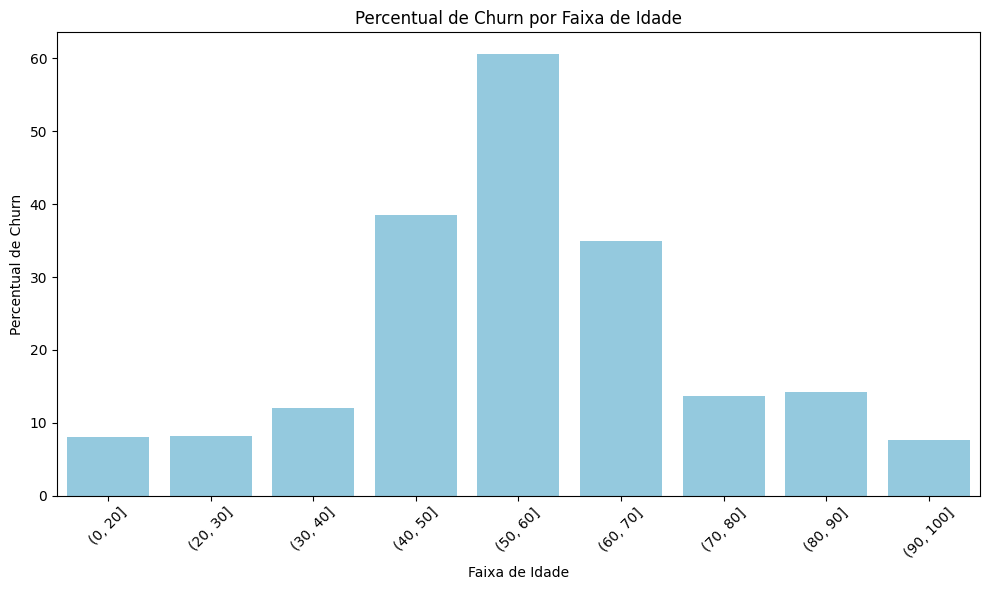

In [14]:

# Definindo as faixas de idade
faixas_idade = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Criando uma nova coluna 'Faixa de Idade' no DataFrame
dados3['Faixa de Idade'] = pd.cut(dados3['Age'], bins=faixas_idade)

# Calculando o percentual de churn por faixa de idade
churn_percent = dados3.groupby('Faixa de Idade')['Exited'].mean() * 100

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_percent.index, y=churn_percent.values, color='skyblue')
plt.title('Percentual de Churn por Faixa de Idade')
plt.xlabel('Faixa de Idade')
plt.ylabel('Percentual de Churn')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###### Os maiores percentuais de churn se encontra na faixa etaria entre 50-60 anos.

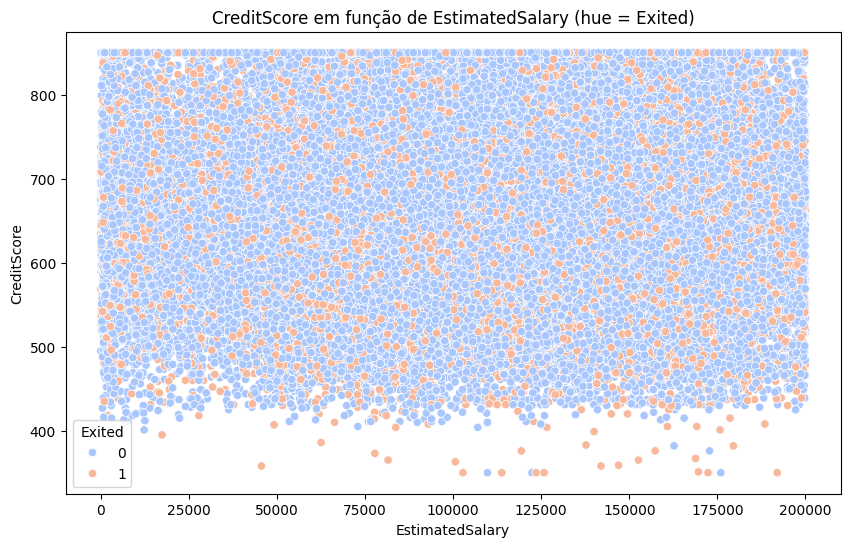

In [15]:
# Plotando o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dados3, x='EstimatedSalary', y='CreditScore', hue='Exited', palette='coolwarm')
plt.title('CreditScore em função de EstimatedSalary (hue = Exited)')
plt.xlabel('EstimatedSalary')
plt.ylabel('CreditScore')
plt.legend(title='Exited')
plt.show()

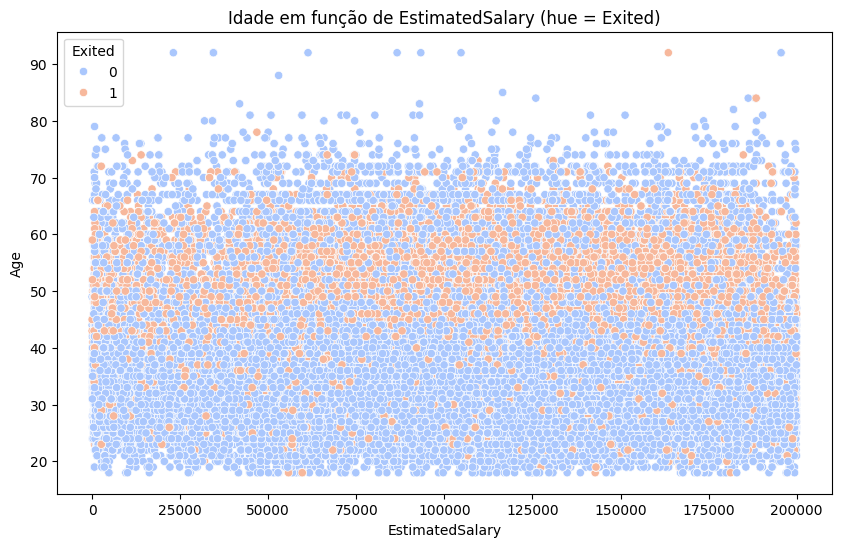

In [16]:
# Plotando o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dados3, x='EstimatedSalary', y='Age', hue='Exited', palette='coolwarm')
plt.title('Idade em função de EstimatedSalary (hue = Exited)')
plt.xlabel('EstimatedSalary')
plt.ylabel('Age')
plt.legend(title='Exited')
plt.show()

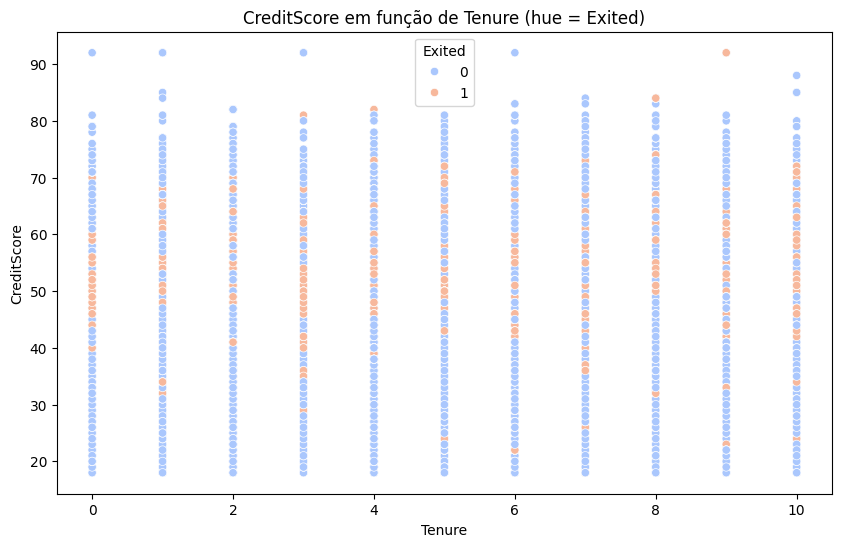

In [17]:
# Plotando o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dados3, x='Tenure', y='Age', hue='Exited', palette='coolwarm')
plt.title('CreditScore em função de Tenure (hue = Exited)')
plt.xlabel('Tenure')
plt.ylabel('CreditScore')
plt.legend(title='Exited')
plt.show()

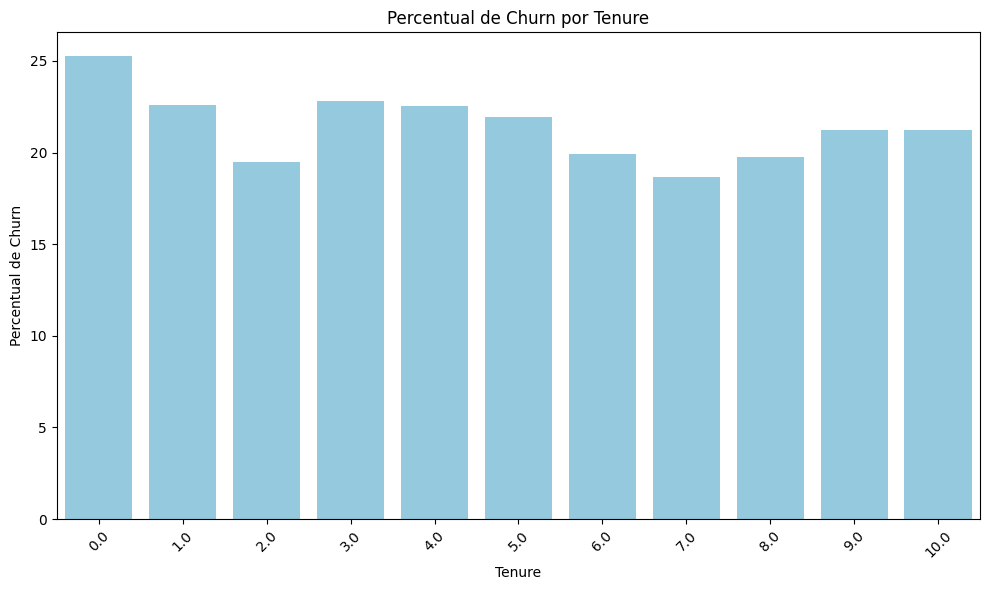

In [18]:
# Calculando a média de churn para cada valor único de tenure
churn_por_tenure = dados3.groupby('Tenure')['Exited'].mean() * 100

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_por_tenure.index, y=churn_por_tenure.values, color='skyblue')
plt.title('Percentual de Churn por Tenure')
plt.xlabel('Tenure')
plt.ylabel('Percentual de Churn')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

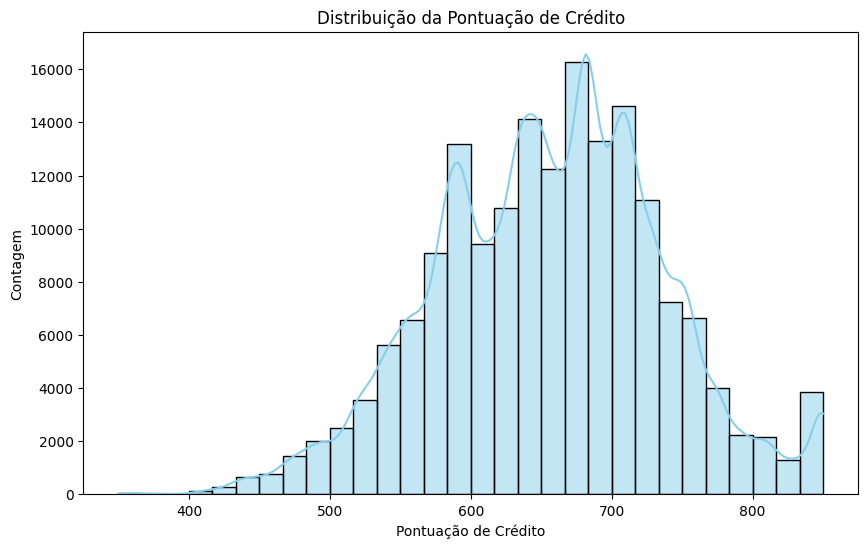

In [19]:
#Qual é a distribuição da pontuação de crédito (CreditScore) dos clientes? 

# Plotando a distribuição da pontuação de crédito (CreditScore)
plt.figure(figsize=(10, 6))
sns.histplot(dados3['CreditScore'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição da Pontuação de Crédito')
plt.xlabel('Pontuação de Crédito')
plt.ylabel('Contagem')
plt.show()

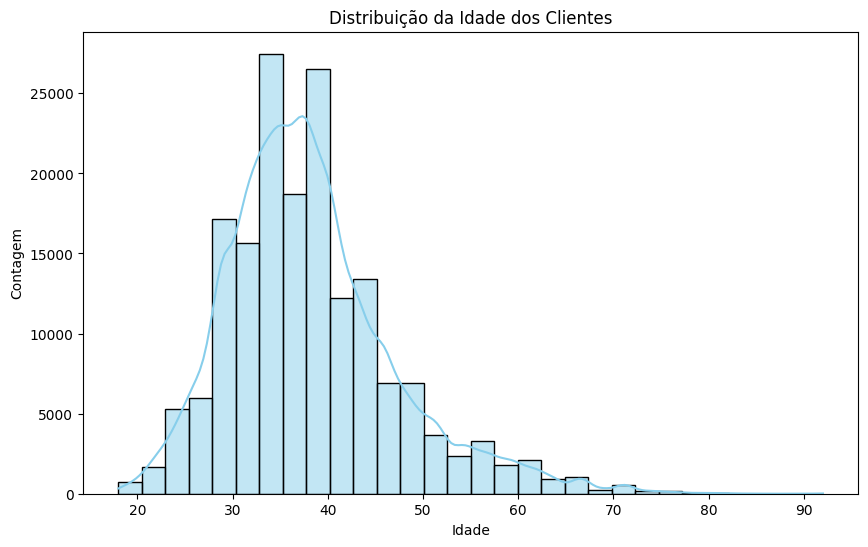

In [20]:
#Como a idade (Age) dos clientes se distribui no conjunto de dados? Existe uma faixa etária predominante entre os clientes?

# Plotando a distribuição da idade (Age)
plt.figure(figsize=(10, 6))
sns.histplot(dados3['Age'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição da Idade dos Clientes')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()


C:\Users\Sávio\AppData\Local\Temp\ipykernel_21380\3805800360.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_percent = dados3.groupby('Faixa de Idade')['Exited'].mean() * 100


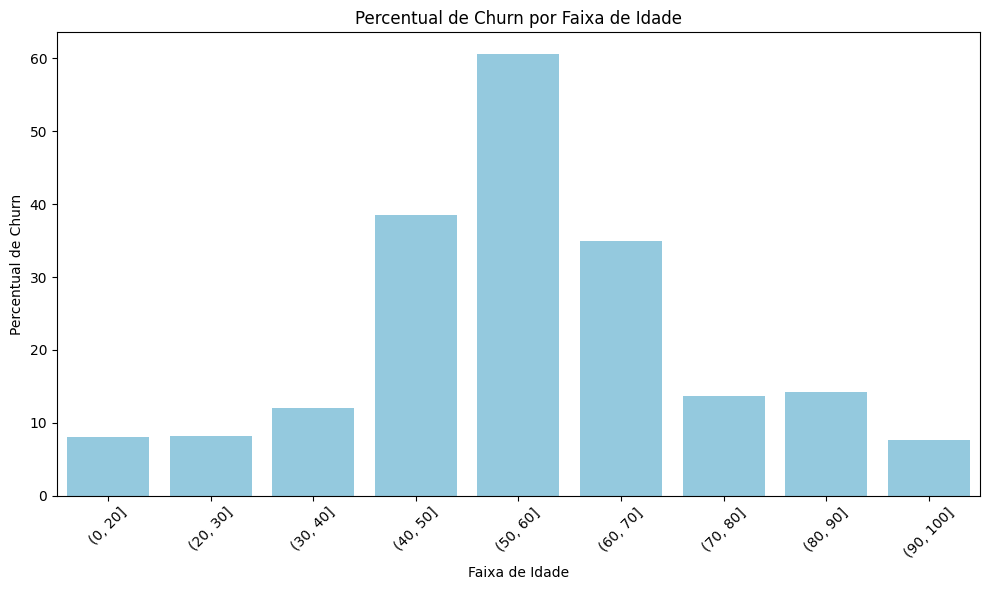

In [21]:
# Definindo as faixas de idade
faixas_idade = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Criando uma nova coluna 'Faixa de Idade' no DataFrame
dados3['Faixa de Idade'] = pd.cut(dados3['Age'], bins=faixas_idade)

# Calculando o percentual de churn por faixa de idade
churn_percent = dados3.groupby('Faixa de Idade')['Exited'].mean() * 100

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_percent.index, y=churn_percent.values, color='skyblue')
plt.title('Percentual de Churn por Faixa de Idade')
plt.xlabel('Faixa de Idade')
plt.ylabel('Percentual de Churn')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:

#Qual é a média e a dispersão do tempo de posse (Tenure) dos clientes? 
#Existe uma relação entre o tempo de posse e outras variáveis, como o saldo na 
#conta (Balance) ou o número de produtos (NumOfProducts)?



# Calculando média e dispersão do tempo de posse (Tenure)
media_tenure = dados3['Tenure'].mean()
desvio_padrao_tenure = dados3['Tenure'].std()

print("Média do tempo de posse (Tenure):", media_tenure)
print("Desvio padrão do tempo de posse (Tenure):", desvio_padrao_tenure)

# Relação entre o tempo de posse (Tenure) e outras variáveis
correlacao_balance_tenure = dados['Balance'].corr(dados3['Tenure'])
correlacao_numofproducts_tenure = dados['NumOfProducts'].corr(dados3['Tenure'])

print("Correlação entre o tempo de posse (Tenure) e o saldo na conta (Balance):", correlacao_balance_tenure)
print("Correlação entre o tempo de posse (Tenure) e o número de produtos (NumOfProducts):", correlacao_numofproducts_tenure)


Média do tempo de posse (Tenure): 5.019951321517946
Desvio padrão do tempo de posse (Tenure): 2.8111662689968178
Correlação entre o tempo de posse (Tenure) e o saldo na conta (Balance): -0.0007467443367123785
Correlação entre o tempo de posse (Tenure) e o número de produtos (NumOfProducts): 0.0015048621870484681


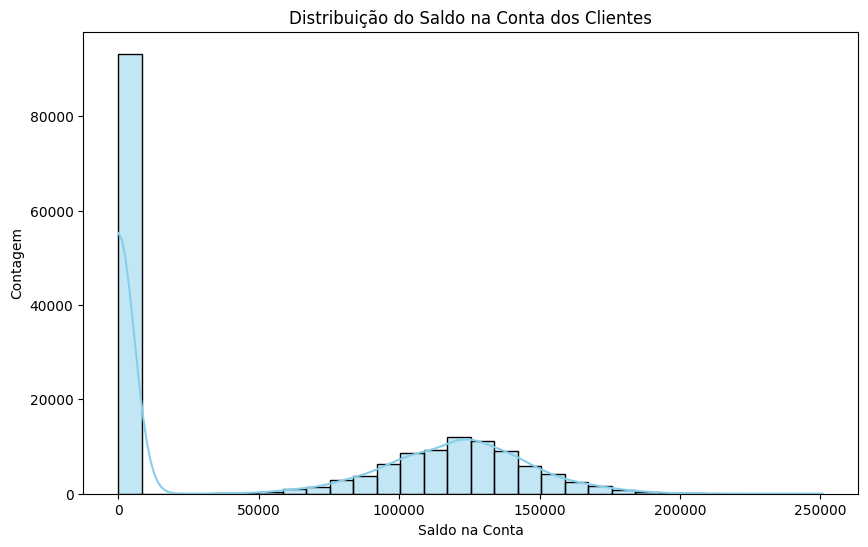

In [23]:
#Como é a distribuição do saldo na conta (Balance) entre os clientes? Existem clientes com saldos muito altos ou negativos?

# Plotando a distribuição do saldo na conta (Balance)
plt.figure(figsize=(10, 6))
sns.histplot(dados3['Balance'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição do Saldo na Conta dos Clientes')
plt.xlabel('Saldo na Conta')
plt.ylabel('Contagem')
plt.show()


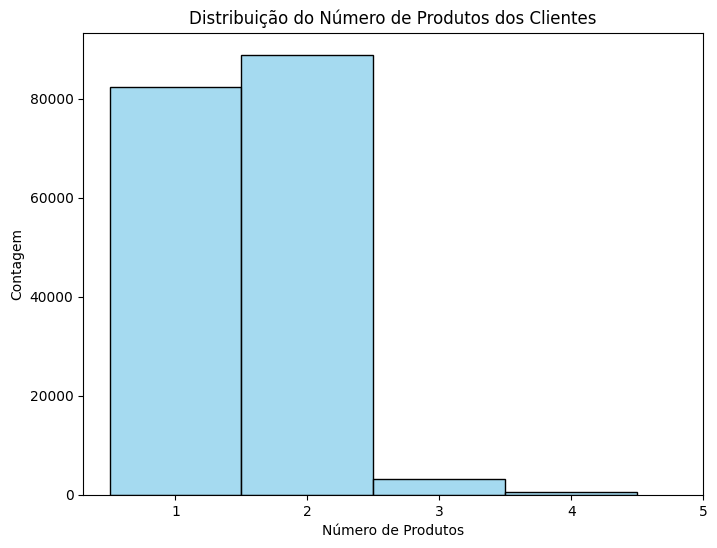

In [24]:
#Qual é a distribuição do número de produtos 
#(NumOfProducts) que os clientes possuem? A maioria dos clientes possui 
#apenas um produto ou há clientes com múltiplos produtos?

# Plotando a distribuição do número de produtos (NumOfProducts)
plt.figure(figsize=(8, 6))
sns.histplot(dados3['NumOfProducts'], bins=range(1, 6), discrete=True, color='skyblue', edgecolor='black')
plt.title('Distribuição do Número de Produtos dos Clientes')
plt.xlabel('Número de Produtos')
plt.ylabel('Contagem')
plt.xticks(range(1, 6))
plt.show()


In [25]:
#Qual é a proporção de clientes que possuem cartão de crédito (HasCrCard)? 
#Existem diferenças significativas entre clientes com e sem cartão de crédito em termos de outras variáveis?

# Calcular a proporção de clientes que possuem cartão de crédito (HasCrCard)
proporcao_has_cr_card = dados3['HasCrCard'].mean()
print("Proporção de clientes que possuem cartão de crédito:", proporcao_has_cr_card)


Proporção de clientes que possuem cartão de crédito: 0.7511855381486179


In [26]:
#Quantos clientes estão ativos (IsActiveMember)? Qual é a relação entre clientes 
#ativos e aqueles que deixaram o banco (Exited)?

total_clientes = dados3.shape[0]
print("Número de clientes :", total_clientes)

# Contar o número de clientes ativos (IsActiveMember)
clientes_ativos = dados3[dados3['IsActiveMember'] == 1].shape[0]
print("Número de clientes ativos:", clientes_ativos)

# Calcular a proporção de clientes ativos em relação ao total de clientes
proporcao_clientes_ativos = clientes_ativos / len(dados3)
print("Proporção de clientes ativos em relação ao total de clientes:", proporcao_clientes_ativos)

# Calcular o número de clientes que deixaram o banco (Exited)
clientes_que_deixaram = dados3[dados3['Exited'] == 1].shape[0]
print("Número de clientes que deixaram o banco:", clientes_que_deixaram)

# Calcular a proporção de clientes que deixaram o banco em relação ao total de clientes
proporcao_clientes_que_deixaram = clientes_que_deixaram / len(dados3)
print("Proporção de clientes que deixaram o banco em relação ao total de clientes:", proporcao_clientes_que_deixaram)


Número de clientes : 175026
Número de clientes ativos: 87295
Proporção de clientes ativos em relação ao total de clientes: 0.4987544707643436
Número de clientes que deixaram o banco: 36957
Proporção de clientes que deixaram o banco em relação ao total de clientes: 0.2111514860649275


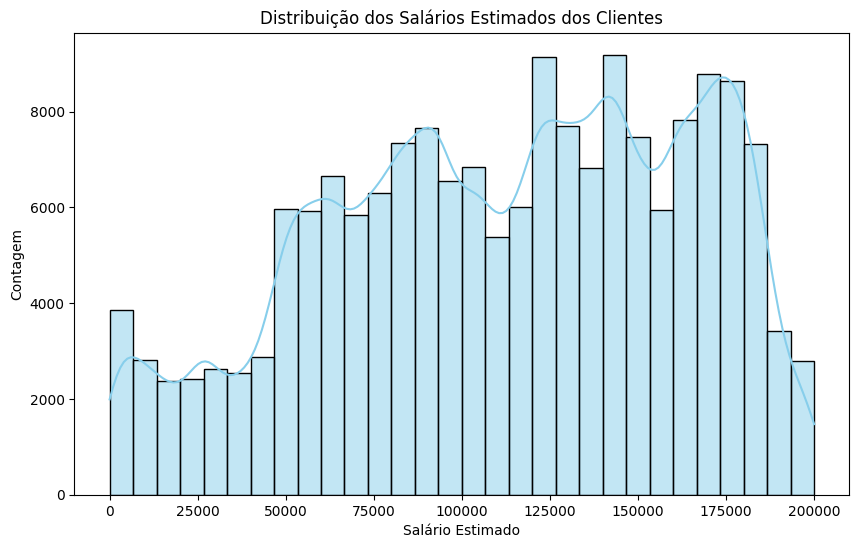

In [27]:
#Como é a distribuição dos salários estimados (EstimatedSalary) dos clientes? Existem faixas salariais específicas que se destacam?


# Plotando a distribuição dos salários estimados (EstimatedSalary)
plt.figure(figsize=(10, 6))
sns.histplot(dados3['EstimatedSalary'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição dos Salários Estimados dos Clientes')
plt.xlabel('Salário Estimado')
plt.ylabel('Contagem')
plt.show()


C:\Users\Sávio\AppData\Local\Temp\ipykernel_21380\3335838674.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Country', data=dados3, palette='viridis')


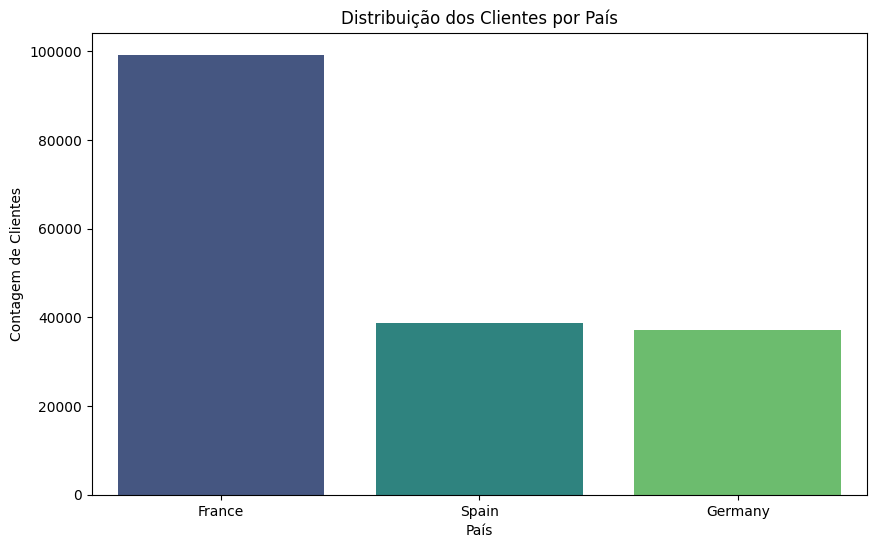

In [28]:
#Como a distribuição dos clientes varia entre os diferentes países (France, Germany, Spain)? 
#Existem diferenças nos comportamentos dos clientes com base no país de residência?

# Criar uma nova coluna 'Country' com base nas colunas 'France', 'Germany' e 'Spain'
dados3['Country'] = dados3[['France', 'Germany', 'Spain']].idxmax(axis=1)

# Plotar a distribuição dos clientes nos diferentes países
plt.figure(figsize=(10, 6))
sns.countplot(x='Country', data=dados3, palette='viridis')
plt.title('Distribuição dos Clientes por País')
plt.xlabel('País')
plt.ylabel('Contagem de Clientes')
plt.show()

# Investigar diferenças nos comportamentos dos clientes com base no país de residência
# Por exemplo, você pode comparar médias, medianas ou outras estatísticas para variáveis específicas,
# agrupando os dados por país e analisando os resultados.



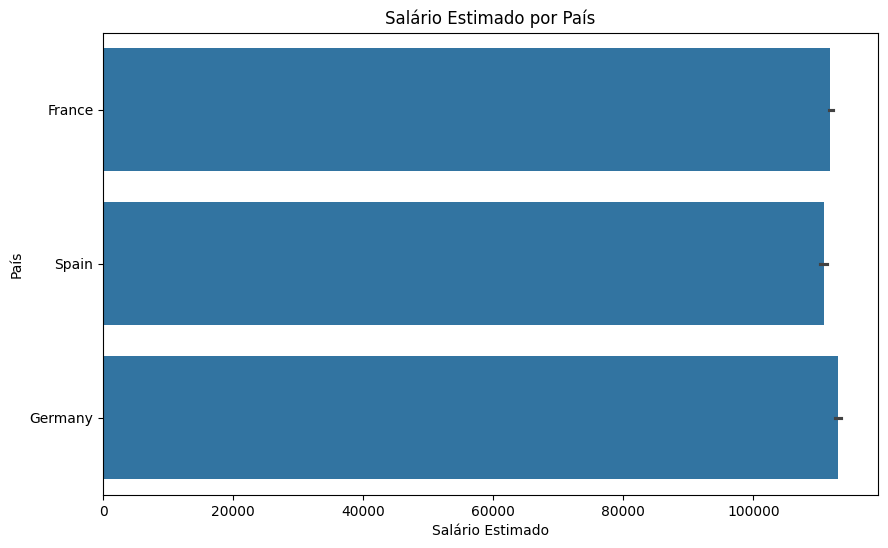

In [29]:
# Criar um gráfico de barras agrupado para mostrar o salário estimado por país
plt.figure(figsize=(10, 6))
sns.barplot(x='EstimatedSalary', y='Country', data=dados3)
plt.title('Salário Estimado por País')
plt.xlabel('Salário Estimado')
plt.ylabel('País')
plt.show()

In [30]:
# Agrupar os dados por país e calcular a média de 'Exited'
percentual_churn = dados3.groupby('Country')['Exited'].mean() * 100

# Exibir o percentual de churn por país
print(percentual_churn)

Country
France     16.510285
Germany    37.524923
Spain      17.183179
Name: Exited, dtype: float64


In [31]:
#Qual é a proporção de clientes do sexo feminino (Female) 
#e masculino (Male) no conjunto de dados? Existem diferenças 
#significativas entre os comportamentos de gênero dos clientes?

# Calcular a proporção de clientes do sexo feminino e masculino
proporcao_female = dados['Female'].mean()
proporcao_male = dados['Male'].mean()

print("Proporção de clientes do sexo feminino:", proporcao_female)
print("Proporção de clientes do sexo masculino:", proporcao_male)

# Investigar diferenças nos comportamentos de gênero dos clientes
# Por exemplo, você pode comparar médias, medianas ou outras estatísticas para variáveis específicas,
# agrupando os dados por gênero e analisando os resultados.


Proporção de clientes do sexo feminino: 0.43664442260666864
Proporção de clientes do sexo masculino: 0.5633555773933313


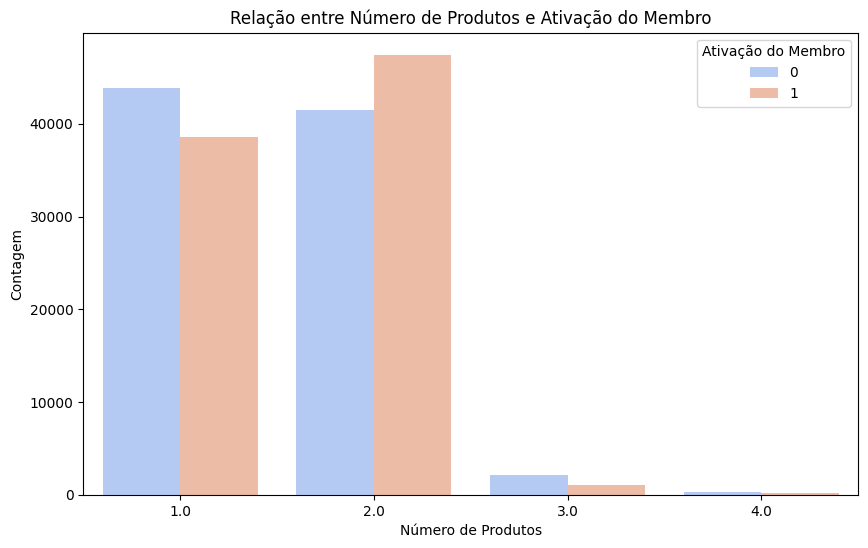

In [32]:
#Como o número de produtos (NumOfProducts) 
#se relaciona com a ativação do membro (IsActiveMember)? 
#Existem clientes com mais produtos que são menos ativos ou vice-versa?

# Plotar um gráfico de barras para visualizar a relação entre o número de produtos e a ativação do membro
plt.figure(figsize=(10, 6))
sns.countplot(x='NumOfProducts', hue='IsActiveMember', data=dados, palette='coolwarm')
plt.title('Relação entre Número de Produtos e Ativação do Membro')
plt.xlabel('Número de Produtos')
plt.ylabel('Contagem')
plt.legend(title='Ativação do Membro', loc='upper right')
plt.show()

#### 0.7 Correlações entre as variáveis


In [33]:


# Calcular correlações entre as variáveis
correlacoes = dados3['Age'].corr(dados3['Tenure'])


# Exibir as correlações
print(correlacoes)


-0.010787954156825784


#### 0.8 Análise de Range

In [34]:
for coluna in dados.columns:
    if dados[coluna].dtype != object:  # Verificar se a coluna é numérica
        min_valor = dados[coluna].min()
        max_valor = dados[coluna].max()
        amplitude = max_valor - min_valor
        print(f'Análise de Range para {coluna}:')
        print(f'Mínimo: {min_valor}, Máximo: {max_valor}, Amplitude: {amplitude}')


Análise de Range para Surname:
Mínimo: 0, Máximo: 2931, Amplitude: 2931
Análise de Range para CreditScore:
Mínimo: 350.0, Máximo: 850.0, Amplitude: 500.0
Análise de Range para Age:
Mínimo: 18.0, Máximo: 92.0, Amplitude: 74.0
Análise de Range para Tenure:
Mínimo: 0.0, Máximo: 10.0, Amplitude: 10.0
Análise de Range para Balance:
Mínimo: 0.0, Máximo: 250898.09, Amplitude: 250898.09
Análise de Range para NumOfProducts:
Mínimo: 1.0, Máximo: 4.0, Amplitude: 3.0
Análise de Range para HasCrCard:
Mínimo: 0, Máximo: 1, Amplitude: 1
Análise de Range para IsActiveMember:
Mínimo: 0, Máximo: 1, Amplitude: 1
Análise de Range para Exited:
Mínimo: 0, Máximo: 1, Amplitude: 1
Análise de Range para France:
Mínimo: 0, Máximo: 1, Amplitude: 1
Análise de Range para Germany:
Mínimo: 0, Máximo: 1, Amplitude: 1
Análise de Range para Spain:
Mínimo: 0, Máximo: 1, Amplitude: 1
Análise de Range para Female:
Mínimo: 0, Máximo: 1, Amplitude: 1
Análise de Range para Male:
Mínimo: 0, Máximo: 1, Amplitude: 1
Análise de 

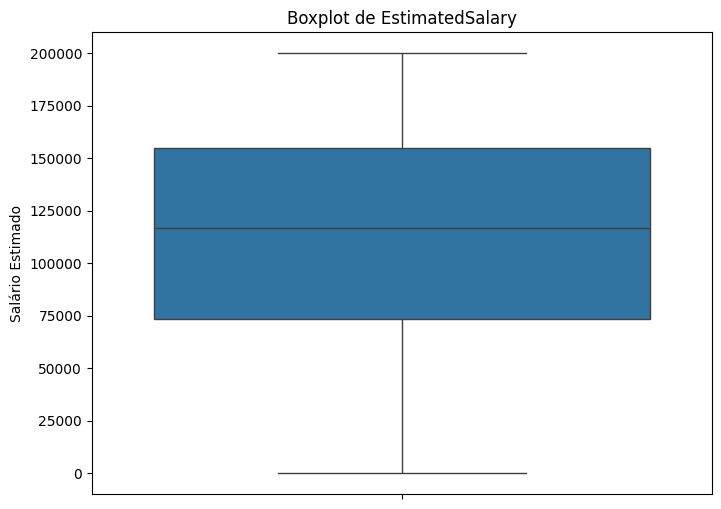

In [35]:
# Criar um boxplot para a coluna 'EstimatedSalary'
plt.figure(figsize=(8, 6))
sns.boxplot(data=dados3, y='EstimatedSalary')
plt.title('Boxplot de EstimatedSalary')
plt.ylabel('Salário Estimado')
plt.show()


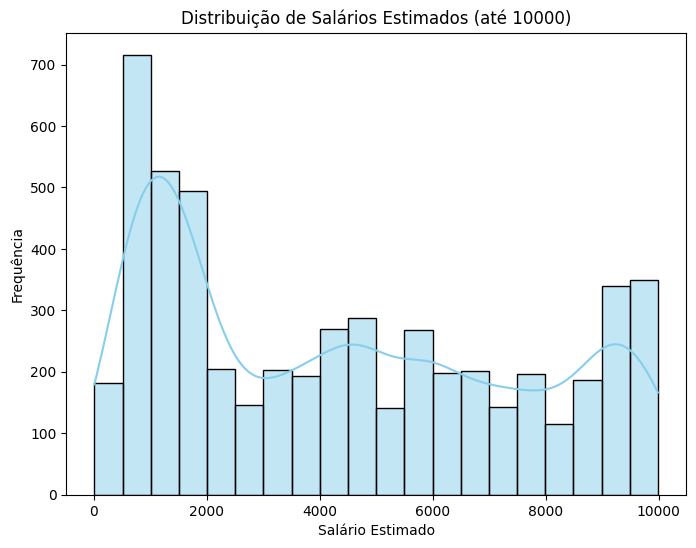

In [36]:

# Filtrar os dados de salário estimado entre 0 e 1000
salarios_filtrados = dados3[dados3['EstimatedSalary'] <= 10000]['EstimatedSalary']

# Criar um histograma da distribuição dos salários estimados
plt.figure(figsize=(8, 6))
sns.histplot(salarios_filtrados, bins=20, kde=True, color='skyblue')
plt.title('Distribuição de Salários Estimados (até 10000)')
plt.xlabel('Salário Estimado')
plt.ylabel('Frequência')
plt.show()


#### Limpeza e Pré Processamento dos Dados
#### 1.0 Valores Nulls

In [37]:
# Identificando valores nulos
print(dados3.isnull().sum())

Surname                    0
CreditScore                0
Age                        0
Tenure                     0
Balance                    0
NumOfProducts              0
HasCrCard                  0
IsActiveMember             0
EstimatedSalary            0
Exited                     0
France                     0
Germany                    0
Spain                      0
Female                     0
Male                       0
Mem__no__Products          0
EstimatedSalary_numeric    0
Faixa de Idade             0
Country                    0
dtype: int64


#### Divisão dos Dados e Treinamento do Modelo
#### 2.0 Divisão em Treino e Teste

In [38]:
# Definindo a coluna 'Surname' como o índice
dados3.set_index('Surname', inplace=True)

# Agora 'Surname' é o índice do DataFrame df
print(dados3.head())


         CreditScore   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
Surname                                                                   
2023           668.0  33.0     3.0       0.00            2.0          1   
2024           627.0  33.0     1.0       0.00            2.0          1   
1236           678.0  40.0    10.0       0.00            2.0          1   
1362           581.0  34.0     2.0  148882.54            1.0          1   
491            716.0  33.0     5.0       0.00            2.0          1   

         IsActiveMember  EstimatedSalary  Exited  France  Germany  Spain  \
Surname                                                                    
2023                  0        181449.97       0       1        0      0   
2024                  1         49503.50       0       1        0      0   
1236                  0        184866.69       0       1        0      0   
1362                  1         84560.88       0       1        0      0   
491               

In [39]:
features = dados3.drop(columns=['Exited', 'Faixa de Idade', 'Country'])  # Todas as colunas exceto 'Exited'
target = dados3['Exited']  # A coluna 'Exited'

In [40]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [41]:
X_train.shape

(140020, 15)

In [42]:
X_test.shape

(35006, 15)

In [43]:
y_train.shape

(140020,)

In [44]:
y_test.shape

(35006,)

#### 2.1 Normalização e Codificação de Variáveis

In [45]:
# Criar um objeto MinMaxScaler
scaler = MinMaxScaler()

# Normalizar as variáveis do conjunto de treino
X_train_normalized = scaler.fit_transform(X_train)

# Usar as mesmas transformações para normalizar as variáveis do conjunto de teste
X_test_normalized = scaler.transform(X_test)

In [46]:
X_train_normalized


array([[0.47      , 0.09459459, 0.1       , ..., 1.        , 0.        ,
        0.20126332],
       [0.554     , 0.40540541, 0.1       , ..., 1.        , 0.        ,
        0.52766014],
       [0.532     , 0.36486486, 0.4       , ..., 0.        , 0.        ,
        0.3099819 ],
       ...,
       [0.642     , 0.09459459, 0.8       , ..., 1.        , 0.        ,
        0.48394942],
       [0.626     , 0.27027027, 0.4       , ..., 1.        , 0.25      ,
        0.13126174],
       [0.482     , 0.32432432, 0.9       , ..., 1.        , 0.5       ,
        0.65877486]])

#### 2.2 Treinamento e Avaliação dos Modelos de Regressão

In [47]:
# Criando e treinando o modelo de regressão logística
logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train_normalized, y_train)

# Fazendo previsões usando o modelo de regressão logística para o conjunto de teste
y_pred_logistic = logistic_reg_model.predict(X_test_normalized)

# Avaliando o desempenho do modelo (por exemplo, acurácia)
accuracy = np.mean(y_pred_logistic == y_test)
print("Acurácia do modelo de regressão logística:", accuracy)


Acurácia do modelo de regressão logística: 0.8294578072330457


In [48]:

# Criando e treinando o modelo de Random Forest para classificação
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_normalized, y_train)

# Fazendo previsões usando o modelo de Random Forest para o conjunto de teste
y_pred_rf = random_forest_model.predict(X_test_normalized)

# Avaliando o desempenho do modelo (por exemplo, acurácia)
accuracy = np.mean(y_pred_rf == y_test)
print("Acurácia do modelo de Random Forest:", accuracy)



Acurácia do modelo de Random Forest: 0.8551676855396217


In [49]:
y_pred_rf

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [50]:
y_test

Surname
2655    0
1470    0
1820    0
1689    0
1228    0
       ..
2863    0
2089    1
2601    0
778     0
2653    1
Name: Exited, Length: 35006, dtype: int64

In [51]:
# Definindo os parâmetros do modelo XGBoost para classificação
params = {
    'objective': 'binary:logistic',  # para problemas de classificação binária
    'eval_metric': 'error',  # métrica de avaliação: erro de classificação
    'learning_rate': 0.2,
    'n_estimators': 200
}

# Criar um objeto DMatrix para os dados de treino e teste
dtrain = xgb.DMatrix(X_train_normalized, label=y_train)
dtest = xgb.DMatrix(X_test_normalized, label=y_test)

# Treinar o modelo XGBoost para classificação
num_rounds = 100  # número de iterações de treinamento
xgb_model = xgb.train(params, dtrain, num_rounds)

# Fazer previsões usando o modelo XGBoost para o conjunto de teste
y_pred_xgb = xgb_model.predict(dtest)

# Convertendo as previsões em classes (0 ou 1)
y_pred_xgb_classes = np.round(y_pred_xgb)

# Calculando a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred_xgb_classes)
print("Acurácia do modelo XGBoost para classificação:", accuracy)



C:\Users\Sávio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:160: UserWarning: [19:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Acurácia do modelo XGBoost para classificação: 0.8641661429469234


In [52]:
# Calculando o percentual de cada valor único na coluna "Exited"
percentages = dados3['Exited'].value_counts(normalize=True) * 100

# Exibindo os percentuais
print("Percentual de cada valor da coluna 'Exited':")
print(percentages)


Percentual de cada valor da coluna 'Exited':
Exited
0    78.884851
1    21.115149
Name: proportion, dtype: float64


In [53]:

# Criando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_xgb_classes)

# Exibindo a matriz de confusão
print("Matriz de Confusão:")
print(conf_matrix)


Matriz de Confusão:
[[26160  1412]
 [ 3343  4091]]


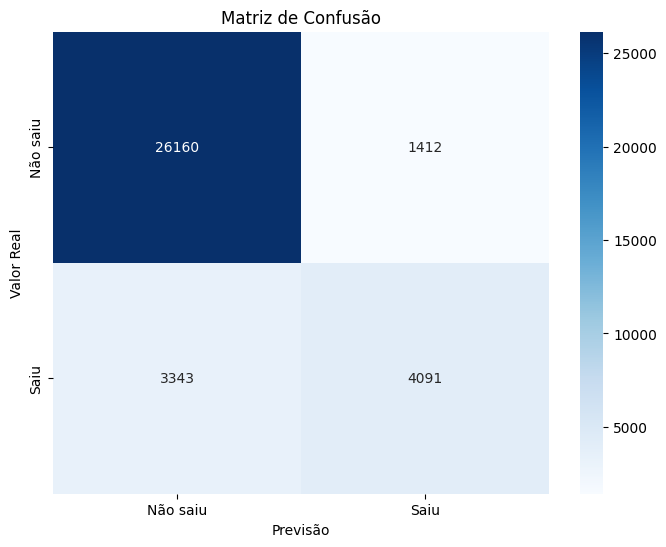

In [54]:
# Definindo os rótulos das classes
class_labels = ['Não saiu', 'Saiu']

# Criando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_xgb_classes)

# Plotando a matriz de confusão com rótulos
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()


In [55]:
# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred_xgb_classes)
print("Acurácia:", accuracy)

# Calculando a precisão
precision = precision_score(y_test, y_pred_xgb_classes)
print("Precisão:", precision)

# Calculando o recall
recall = recall_score(y_test, y_pred_xgb_classes)
print("Recall:", recall)


Acurácia: 0.8641661429469234
Precisão: 0.7434126839905506
Recall: 0.5503093892924401


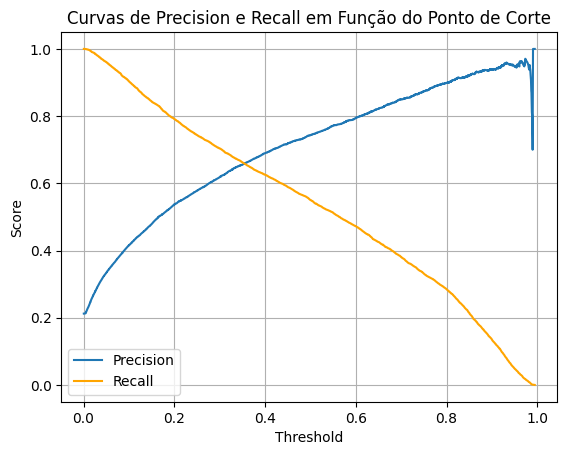

In [56]:
# Calculando a precisão e o recall para diferentes pontos de corte
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_xgb)

# Plotando as curvas de precision e recall juntas
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall', color='orange')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Curvas de Precision e Recall em Função do Ponto de Corte')
plt.legend()
plt.grid(True)
plt.show()



In [57]:

# Definindo os parâmetros do modelo XGBoost para classificação
params = {
    'objective': 'binary:logistic',  # para problemas de classificação binária
    'eval_metric': 'error',  # métrica de avaliação: erro de classificação
}

# Criar um objeto DMatrix para os dados de treino e teste
dtrain = xgb.DMatrix(X_train_normalized, label=y_train)
dtest = xgb.DMatrix(X_test_normalized, label=y_test)

# Definindo a grade de hiperparâmetros para otimização
param_dist = {
    'learning_rate': uniform(0.01, 0.05),  # taxa de aprendizado
    'n_estimators': randint(200, 500),  # número de árvores
    'max_depth': randint(5, 8),  # profundidade máxima da árvore
    'min_child_weight': randint(3, 12),  # peso mínimo da criança
}

# Criar um objeto RandomizedSearchCV
xgb_random = RandomizedSearchCV(xgb.XGBClassifier(**params), param_distributions=param_dist,
                                n_iter=100, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Realizar a busca aleatória nos hiperparâmetros
xgb_random.fit(X_train_normalized, y_train)

# Obter os melhores parâmetros encontrados
best_params = xgb_random.best_params_

# Criar um modelo XGBoost com os melhores parâmetros encontrados
best_xgb_model = xgb.XGBClassifier(**params, **best_params)

# Treinar o modelo com os melhores parâmetros
best_xgb_model.fit(X_train_normalized, y_train)

# Fazer previsões usando o modelo XGBoost otimizado para o conjunto de teste
y_pred_xgb = best_xgb_model.predict(X_test_normalized)

# Calculando a acurácia do modelo otimizado
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Acurácia do modelo XGBoost otimizado para classificação:", accuracy)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Acurácia do modelo XGBoost otimizado para classificação: 0.8648517397017654


In [58]:
best_params

{'learning_rate': 0.032994893568314435,
 'max_depth': 6,
 'min_child_weight': 9,
 'n_estimators': 290}

In [59]:

# Criar DataFrame com y_test, y_pred e y_pred_xgb
df_results = pd.DataFrame({'y_test': y_test, 'y_pred_xgb': y_pred_xgb})

# Visualizar o DataFrame
df_results


,y_test,y_pred_xgb
Surname,,
2655,0,0
1470,0,1
1820,0,0
1689,0,0
1228,0,1
...,...,...
2863,0,0
2089,1,1
2601,0,0


In [60]:

# Criar DataFrame com y_test, y_pred_xgb e probabilidades previstas
df_results = pd.DataFrame({'y_test': y_test, 'y_pred_xgb': y_pred_xgb, 'prob_xgb': best_xgb_model.predict_proba(X_test_normalized)[:,1]})

# Visualizar o DataFrame
df_results


,y_test,y_pred_xgb,prob_xgb
Surname,,,
2655,0,0,0.079320
1470,0,1,0.564897
1820,0,0,0.259478
1689,0,0,0.024361
1228,0,1,0.721497
...,...,...,...
2863,0,0,0.018215
2089,1,1,0.796603
2601,0,0,0.364680


In [61]:

# Definindo o novo ponto de corte
novo_ponto_corte = 0.6  # Altere este valor conforme desejado

# Gerando as classes previstas com base no novo ponto de corte
y_pred_xgb_classes = np.where(best_xgb_model.predict_proba(X_test_normalized)[:,1] >= novo_ponto_corte, 1, 0)

# Criar DataFrame com y_test, y_pred e y_pred_xgb_classes
df_results = pd.DataFrame({'y_test': y_test, 'y_pred_xgb': y_pred_xgb_classes,'prob_xgb': best_xgb_model.predict_proba(X_test_normalized)[:,1]})

# Visualizar o DataFrame
df_results.head(20)


,y_test,y_pred_xgb,prob_xgb
Surname,,,
2655,0,0,0.079320
1470,0,0,0.564897
1820,0,0,0.259478
1689,0,0,0.024361
1228,0,1,0.721497
2654,1,0,0.368308
1949,1,1,0.935973
2775,1,0,0.168454
1306,0,0,0.156625


In [62]:

# Definindo o novo ponto de corte
novo_ponto_corte = 0.6  # Altere este valor conforme desejado

# Gerando as classes previstas com base no novo ponto de corte
y_pred_xgb_classes = np.where(best_xgb_model.predict_proba(X_test_normalized)[:,1] >= novo_ponto_corte, 1, 0)

# Criar DataFrame com y_test, y_pred e y_pred_xgb_classes
df_results = pd.DataFrame({'y_test':y_test, 'y_pred_xgb': y_pred_xgb_classes,'prob_xgb': best_xgb_model.predict_proba(X_test_normalized)[:,1]})

# Visualizar o DataFrame
df_results.head(20)

,y_test,y_pred_xgb,prob_xgb
Surname,,,
2655,0,0,0.079320
1470,0,0,0.564897
1820,0,0,0.259478
1689,0,0,0.024361
1228,0,1,0.721497
2654,1,0,0.368308
1949,1,1,0.935973
2775,1,0,0.168454
1306,0,0,0.156625


In [63]:
# Definindo o novo ponto de corte
novo_ponto_corte = 0.6  # Altere este valor conforme desejado

# Gerando as classes previstas com base no novo ponto de corte
y_pred_xgb_classes = np.where(best_xgb_model.predict_proba(X_test_normalized)[:,1] >= novo_ponto_corte, 1, 0)

# Criar DataFrame com y_test, y_pred e prob_xgb
df_results = pd.DataFrame({'y_test': y_test, 'y_pred_xgb': y_pred_xgb_classes, 'prob_xgb': best_xgb_model.predict_proba(X_test_normalized)[:,1]})

# Filtrar as linhas onde prob_xgb é maior ou igual a 0.9
df_filtered = df_results.loc[df_results['prob_xgb'] >= 0.9]

# Visualizar o DataFrame filtrado
df_filtered.head(20)


,y_test,y_pred_xgb,prob_xgb
Surname,,,
1949,1,1,0.935973
1971,1,1,0.937628
1218,1,1,0.915162
1230,1,1,0.948884
479,1,1,0.976441
2587,1,1,0.904708
1865,1,1,0.923276
984,1,1,0.904636
2546,1,1,0.933189


In [64]:
# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred_xgb_classes)
print("Acurácia:", accuracy)

# Calculando a precisão
precision = precision_score(y_test, y_pred_xgb_classes)
print("Precisão:", precision)

# Calculando o recall
recall = recall_score(y_test, y_pred_xgb_classes)
print("Recall:", recall)

Acurácia: 0.8610809575501343
Precisão: 0.7983290786725459
Recall: 0.4627387678235136


#### 3.0 Conclusão
#### Concluo o projeto com um modelo preditivo que identifica clientes com alta probabilidade de churn. O modelo alcançou uma precisão de 80%, ou seja, 80% dos clientes previstos para churn realmente deixam a empresa. Além disso, o modelo identificou 46% dos churns totais, permitindo à empresa adotar medidas preventivas e estratégias de retenção mais eficazes.